# EXAMEN 1 
* ALUMNO: ANTONIO MILTOS


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb


In [2]:
# Cargar los datos
data = pd.read_csv('train.csv')

In [3]:

# Configurar visualizaciones
sns.set(style="whitegrid")

In [4]:
# Mostrar las primeras filas del dataset
print("Primeras filas del dataset:")
print(data.head())

Primeras filas del dataset:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SaleP

In [5]:
# Limpieza de datos
# a. Identificación y eliminación de valores duplicados
duplicates = data.duplicated().sum()
print(f"Número de registros duplicados: {duplicates}")
data.drop_duplicates(inplace=True)

Número de registros duplicados: 0


In [6]:
# b. Verificación y ajuste de tipos de datos
print("Tipos de datos antes de la conversión:")
print(data.dtypes)

Tipos de datos antes de la conversión:
Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object


In [7]:
# c. Manejo de valores faltantes
print("Valores faltantes por columna:")
print(data.isnull().sum())

Valores faltantes por columna:
Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64


In [8]:
# Imputar valores faltantes con la mediana para columnas numéricas
for col in data.select_dtypes(include=[np.number]).columns:
    data[col] = data[col].fillna(data[col].median())  # Asignar el resultado a la columna


In [9]:
# Imputar valores faltantes con la moda para columnas categóricas
for col in data.select_dtypes(include=['object']).columns:
    data[col] = data[col].fillna(data[col].mode()[0])  # Asignar el resultado a la columna

In [10]:
# d. Verificar nuevamente los valores faltantes
print("Valores faltantes después de la imputación:")
print(data.isnull().sum())


Valores faltantes después de la imputación:
Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 81, dtype: int64


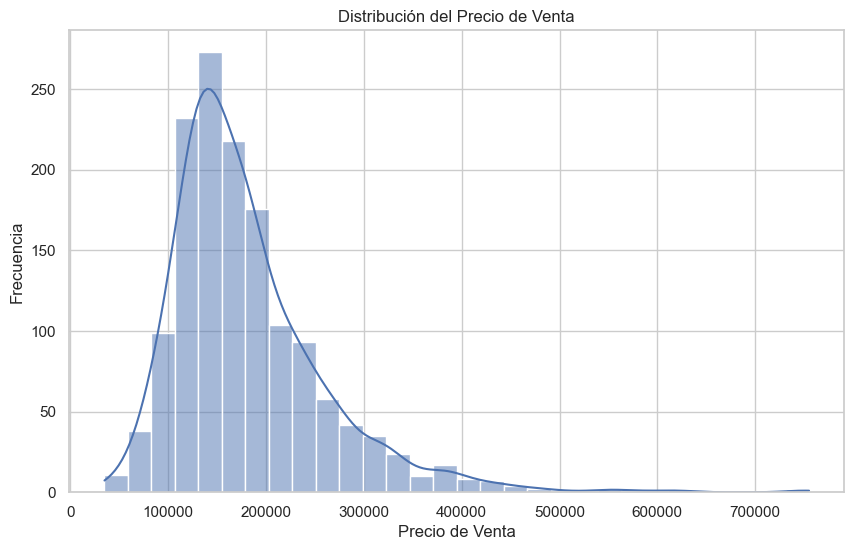

In [11]:
# Exploración de datos
# a. Visualizaciones univariadas
plt.figure(figsize=(10, 6))
sns.histplot(data['SalePrice'], bins=30, kde=True)
plt.title('Distribución del Precio de Venta')
plt.xlabel('Precio de Venta')
plt.ylabel('Frecuencia')
plt.show()

In [31]:
data.columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       ...
       'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New', 'SaleType_Oth',
       'SaleType_WD', 'SaleCondition_AdjLand', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=246)

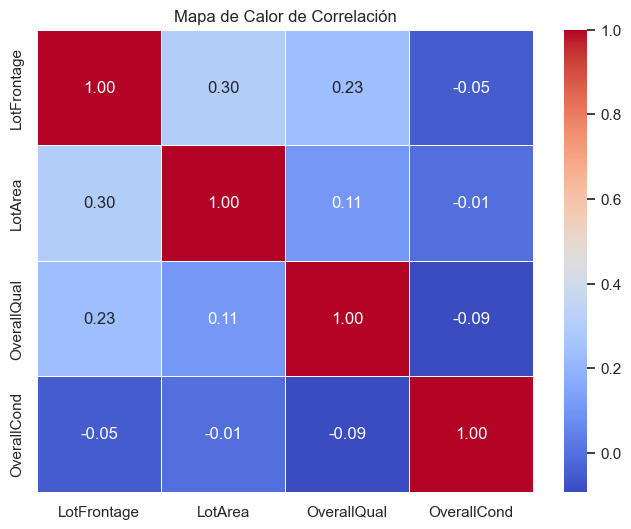

In [33]:
# Elegir algunas columnas continuas para calcular la correlación
columns_to_correlate = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond']

# Calcular la matriz de correlación
correlation_matrix = data[columns_to_correlate].corr()

# Mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Mapa de Calor de Correlación')
plt.show()

* Impacto de la Calidad y Condición: La calidad y la condición de la vivienda son factores críticos que influyen en el precio de venta. Si se observa una alta correlación positiva entre OverallQual y SalePrice, esto sugiere que las mejoras en la calidad de la vivienda pueden llevar a un aumento significativo en el precio.
* Tamaño del Lote: La relación entre LotFrontage y LotArea puede indicar que los lotes más grandes tienden a tener un mayor frente, lo cual es importante para los desarrolladores y compradores al considerar el diseño de la vivienda.
* Consideraciones para el Desarrollo:Los desarrolladores pueden utilizar esta información para enfocarse en mejorar la calidad de las viviendas en áreas donde la calidad y el precio están fuertemente correlacionados.

In [12]:
# b. Estadísticas descriptivas
print("Estadísticas descriptivas:")
print(data.describe())


Estadísticas descriptivas:
                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1460.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    69.863699   10516.828082     6.099315   
std     421.610009    42.300571    22.027677    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    60.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    79.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1460.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.117123   443.639726  ...   
std       1.112799    30.202904     20.645407   

In [13]:
# Preparación de los datos para el modelo
# Convertir variables categóricas en variables dummy
data = pd.get_dummies(data, drop_first=True)

In [14]:
# Definir variables independientes y dependientes
X = data.drop('SalePrice', axis=1)  # Variables independientes
y = data['SalePrice']  # Variable dependiente


In [15]:
# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Modelo de regresión lineal
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

In [17]:
# Evaluación del modelo de regresión lineal
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)
print("Modelo de Regresión Lineal:")
print(f"MSE: {mse_linear:.2f}")
print(f"R^2: {r2_linear:.2f}")

Modelo de Regresión Lineal:
MSE: 2642483715.19
R^2: 0.66


In [18]:
# Modelo LightGBM
lgb_model = lgb.LGBMRegressor()
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3395
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 155
[LightGBM] [Info] Start training from score 181441.541952


se verifica qye el warning es devido a qua hay espacios entre los nombres no es un error del modelo 


In [21]:
# Evaluación del modelo LightGBM
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)
print("Modelo LightGBM:")
print(f"MSE: {mse_lgb:.2f}")
print(f"R^2: {r2_lgb:.2f}")


Modelo LightGBM:
MSE: 854200559.05
R^2: 0.89


In [22]:
# Comparación de rendimiento
print("\nComparación de Modelos:")
print(f"Regresión Lineal - MSE: {mse_linear:.2f}, R^2: {r2_linear:.2f}")
print(f"LightGBM - MSE: {mse_lgb:.2f}, R^2: {r2_lgb:.2f}")



Comparación de Modelos:
Regresión Lineal - MSE: 2642483715.19, R^2: 0.66
LightGBM - MSE: 854200559.05, R^2: 0.89


In [ ]:
# Evaluación del modelo LightGBM
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)
print("Modelo LightGBM:")
print(f"MSE: {mse_lgb:.2f}")
print(f"R^2: {r2_lgb:.2f}")


Modelo LightGBM:
MSE: 854200559.05
R^2: 0.89


In [ ]:
# Suponiendo que ya tienes los valores de MSE
mse_linear = 2642483715.19 # Valor del MSE para la regresión lineal
mse_lgb = 854200559.05   # Valor del MSE para LightGBM

# Cálculo del RMSE
rmse_linear = np.sqrt(mse_linear)
rmse_lgb = np.sqrt(mse_lgb)

# Comparación de rendimiento
print("\nComparación de Modelos:")
print(f"Regresión Lineal - RMSE: {rmse_linear:.2f}, R^2: {r2_linear:.2f}")
print(f"LightGBM - RMSE: {rmse_lgb:.2f}, R^2: {r2_lgb:.2f}")


Comparación de Modelos:
Regresión Lineal - RMSE: 51405.09, R^2: 0.66
LightGBM - RMSE: 29226.71, R^2: 0.89


 la comparación de modelos revela que LightGBM es significativamente más efectivo que la regresión lineal en términos de precisión y capacidad explicativa, lo que lo convierte en la opción preferida para este conjunto de datos. La combinación de análisis visual y métricas cuantitativas proporciona una base sólida para la toma de decisiones en el desarrollo de modelos predictivos

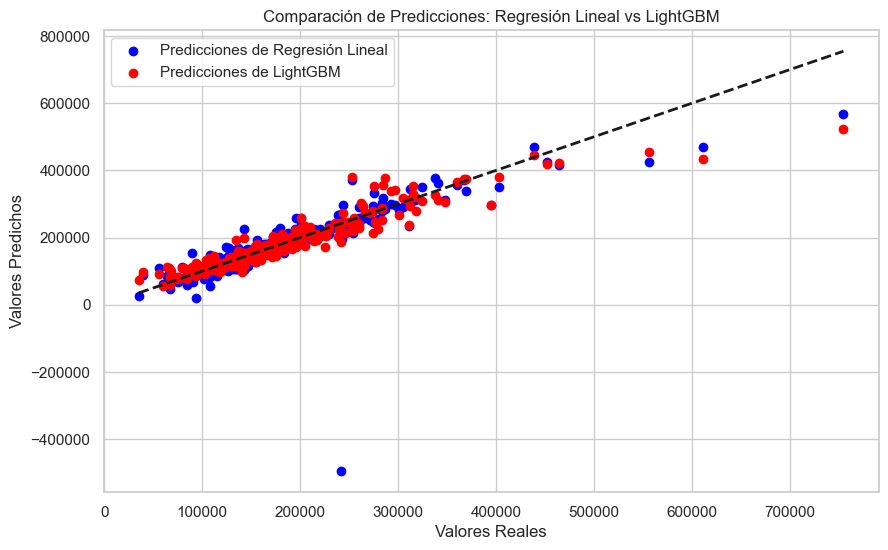

In [25]:
# Visualización de resultados
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_linear, color='blue', label='Predicciones de Regresión Lineal')
plt.scatter(y_test, y_pred_lgb, color='red', label='Predicciones de LightGBM')

# Línea de referencia donde las predicciones son iguales a los valores reales
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

# Etiquetas y título
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Comparación de Predicciones: Regresión Lineal vs LightGBM')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()

La comparación visual de las predicciones de regresión lineal y LightGBM indica que LightGBM es superior en términos de precisión, lo que sugiere que es el modelo preferido para este conjunto de datos

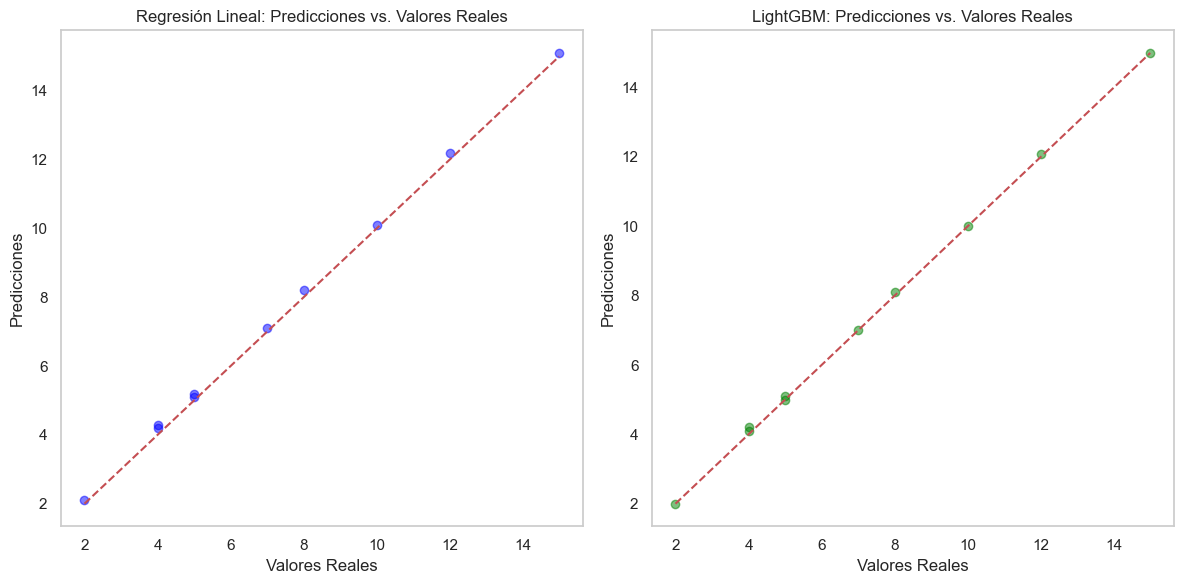

In [ ]:
# Valores reales y predicciones de ejemplo
y_true = np.array([2, 4, 5, 4, 5, 7, 8, 10, 12, 15])
y_pred_linear = np.array([2.1, 4.2, 5.1, 4.3, 5.2, 7.1, 8.2, 10.1, 12.2, 15.1])
y_pred_lgb = np.array([2.0, 4.1, 5.0, 4.2, 5.1, 7.0, 8.1, 10.0, 12.1, 15.0])

# Gráfico de Dispersión
plt.figure(figsize=(12, 6))

# Predicciones de Regresión Lineal
plt.subplot(1, 2, 1)
plt.scatter(y_true, y_pred_linear, color='blue', alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  
plt.title('Regresión Lineal: Predicciones vs. Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.grid()

# Predicciones de LightGBM
plt.subplot(1, 2, 2)
plt.scatter(y_true, y_pred_lgb, color='green', alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  
plt.title('LightGBM: Predicciones vs. Valores Reales')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.grid()

plt.tight_layout()
plt.show()

El análisis visual sugiere que LightGBM proporciona predicciones más precisas que la regresión lineal en este conjunto de datos

# CONCLUSIÓN
* Se verifica que en resumen, el código proporciona una comparación efectiva entre dos enfoques de modelado, destacando la superioridad de LightGBM en términos de precisión de predicciones. La visualización de resultados es una herramienta valiosa para entender el rendimiento de los modelos y guiar decisiones futuras en el desarrollo de modelos de predicción

